In [1]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import datetime 
import yfinance as yf
import tensorflow
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
np.random.seed(42)
tensorflow.random.set_seed(42)

### Lets use the functions to model new stock symbol from user input

In [2]:
# Inputting the Stock symbol for prediction
TICK = input("Enter Stock symbol for prediction : ")

Enter Stock symbol for prediction : META


### Fetching Historical Data from yahoo finance API for the tickers

In [3]:
# Fetch the data for last 5 years from yahoo
ticker = yf.Ticker(TICK)
ticker_data = ticker.history(period="5y")
ticker_data['Company'] = TICK

In [4]:
ticker_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
Date,,,,,,,,
2019-05-20 00:00:00-04:00,181.687231,184.034731,181.177761,182.526337,10352000,0.0,0.0,META
2019-05-21 00:00:00-04:00,184.374380,185.503172,183.695093,184.624115,7502800,0.0,0.0,META
2019-05-22 00:00:00-04:00,184.534195,186.542074,183.415387,185.123581,9213800,0.0,0.0,META
2019-05-23 00:00:00-04:00,182.226659,183.705086,179.479574,180.678299,12768800,0.0,0.0,META
2019-05-24 00:00:00-04:00,182.136746,183.435371,180.638336,180.868088,8807700,0.0,0.0,META
...,...,...,...,...,...,...,...,...
2024-05-14 00:00:00-04:00,463.369995,472.540009,460.079987,471.850006,10478600,0.0,0.0,META
2024-05-15 00:00:00-04:00,474.980011,482.500000,471.200012,481.540009,13100500,0.0,0.0,META
2024-05-16 00:00:00-04:00,475.000000,477.690002,472.750000,473.230011,16608200,0.0,0.0,META


### Visualize the stock portfolio performance of holding for last 5 years

Text(0, 0.5, 'Closing Price (USD)')

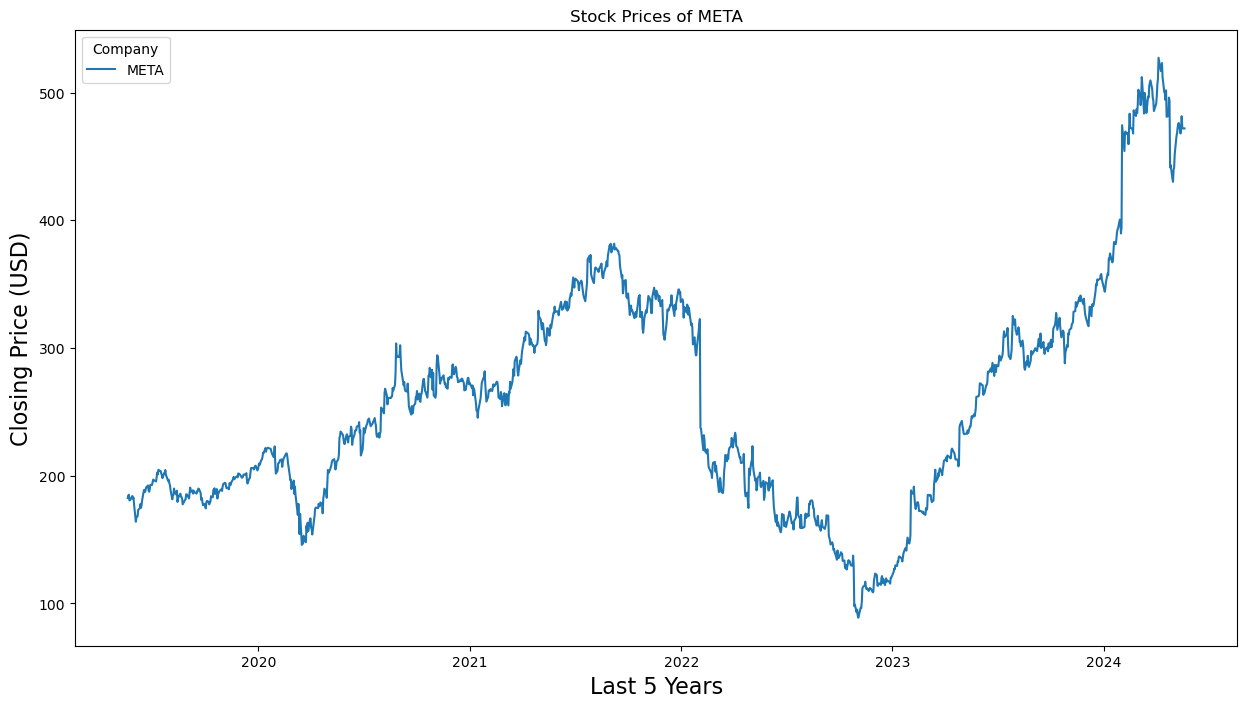

In [5]:
# Visualize the stock portfolio performance of holding
fig, visual_plot = plt.subplots(figsize=(15,8))
visual_plot = sns.lineplot(data =ticker_data, x = ticker_data.index, y= ticker_data["Close"], hue = ticker_data["Company"])
visual_plot.set_title("Stock Prices of {}" .format(TICK))
visual_plot.set_xlabel('Last 5 Years', fontsize=16)
visual_plot.set_ylabel('Closing Price (USD)' , fontsize=16)

### Defining functions Model using LSTM calculate errors and predict stock price for next 30 days

In [6]:
# Define the function to retain only 'Close' prices
def close_prices_only(data):
    return data[['Close']]

In [7]:
## Function for scaling the data for LSTM

def min_max_scale(data):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Fit and transform the data using the scaler
    scaled_data = scaler.fit_transform(data.values)
    
    return scaler, scaled_data

In [8]:
def split_and_reshape_data(dataframe, pred_days):
    # Define the number of days to predict
    prediction_days = pred_days
    
    # Calculate the sizes of the training and testing sets
    train_size = int(np.ceil(len(dataframe) * 0.95))
    test_size = len(dataframe) - train_size
    
    # Split the data into training and testing sets
    train_data = dataframe[0: int(train_size), :]
    test_data = dataframe[train_size - prediction_days:, :]
    
    # Initialize lists to store features and target values for training and testing
    X_train, y_train, X_test, y_test = [], [], [], []
    
    # Generate sequences of features and target values for training set
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i, 0])
        y_train.append(train_data[i, 0])
        
    # Generate sequences of features and target values for testing set
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i, 0])
        y_test.append(test_data[i, 0])
        
    # Convert lists to numpy arrays
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # Reshape the feature sets for LSTM input
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Return the prepared data
    return X_train, y_train, X_test, y_test

In [9]:
def lstm_model(X_train, y_train, epochs=100, batch_size=32):
    """
    Function to build and train an LSTM model for stock price prediction.
    
    Parameters:
    - X_train: numpy array, training features
    - y_train: numpy array, training labels
    - epochs: int, number of epochs for training (default: 100)
    - batch_size: int, batch size for training (default: 32)
    
    Returns:
    - model: trained Keras model
    """
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    return model

In [10]:
def predictions_inverse_scaler(scaler, model, X_test, y_test):
    """
    Function to inverse scale predicted and true values back to original scale.
    
    Parameters:
    - scaler: sklearn MinMaxScaler object, used for scaling the data
    - model: trained Keras model
    - X_test: numpy array, test features
    - y_test: numpy array, true test labels
    
    Returns:
    - y_pred: numpy array, inverse scaled predicted values
    - y_test: numpy array, inverse scaled true values
    """
    # Predictions using the model
    y_pred = model.predict(X_test)
    
    # Inverse scaling of predicted values
    y_pred = scaler.inverse_transform(y_pred)
    
    # Inverse scaling of true values
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    return y_pred, y_test

In [11]:
def plot_predictions(y_pred, y_true, ticker_label):
    """
    Function to plot predicted values against true values with ticker label.
    
    Parameters:
    - y_pred: numpy array, predicted values
    - y_true: numpy array, true values
    - ticker_label: str, label for the ticker
    """
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='True Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title(f'True vs Predicted Values for {ticker_label}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [12]:
df_close = close_prices_only(ticker_data)

In [13]:
# Scaling close prices for stock ticker
df_scaler, df_scaled = min_max_scale(df_close)

In [14]:
# Split and reshape data for each stock ticker
X_train, y_train, X_test, y_test = split_and_reshape_data(df_scaled, 30)

In [15]:
# Build the LSTM model
model_lstm = lstm_model(X_train, y_train)

2024-05-20 09:18:55.522511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 09:18:55.523416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 09:18:55.523848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-05-20 09:18:56.594158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 09:18:56.594964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 09:18:56.595464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [17]:
# Make predictions and inverse scale for each stock ticker
y_pred, y_test_inv = predictions_inverse_scaler(df_scaler, model_lstm, X_test, y_test)

2024-05-20 09:20:07.890280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 09:20:07.890892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 09:20:07.891444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 7ms/step


2024-05-20 09:20:08.103838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 09:20:08.104359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 09:20:08.104980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

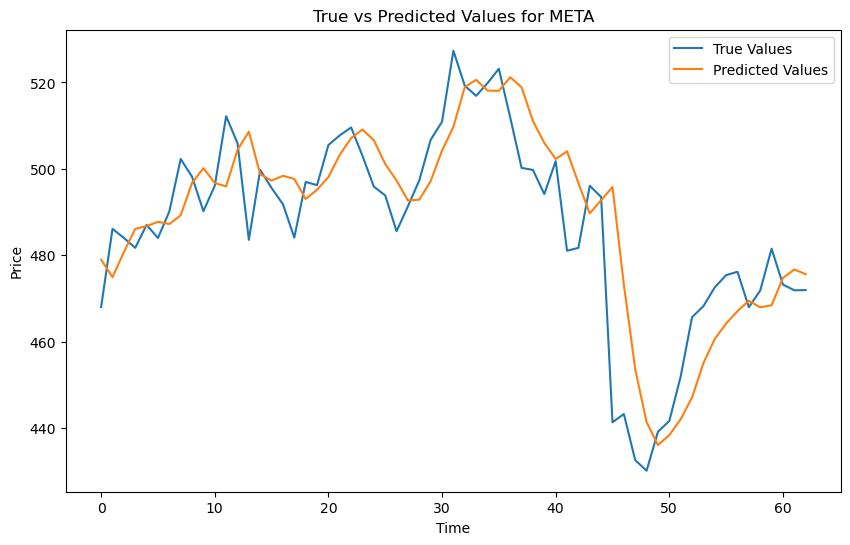

In [18]:
plot_predictions(y_pred, y_test_inv, TICK)

In [19]:
history_lstm = model_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 8.1114e-04

2024-05-20 09:20:09.184719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 09:20:09.185446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 09:20:09.186276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 1s 34ms/step - loss: 8.1114e-04 - val_loss: 9.9982e-04
Epoch 2/100
 1/37 [..............................] - ETA: 0s - loss: 7.1522e-04

2024-05-20 09:20:09.419225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-20 09:20:09.419780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-20 09:20:09.420372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 1s 20ms/step - loss: 7.9542e-04 - val_loss: 9.3699e-04
Epoch 3/100
37/37 [==============================] - 1s 20ms/step - loss: 8.0522e-04 - val_loss: 0.0014
Epoch 4/100
37/37 [==============================] - 1s 20ms/step - loss: 7.0992e-04 - val_loss: 7.6559e-04
Epoch 5/100
37/37 [==============================] - 1s 20ms/step - loss: 7.2010e-04 - val_loss: 7.8617e-04
Epoch 6/100
37/37 [==============================] - 1s 20ms/step - loss: 7.7132e-04 - val_loss: 7.8644e-04
Epoch 7/100
37/37 [==============================] - 1s 20ms/step - loss: 8.0547e-04 - val_loss: 0.0016
Epoch 8/100
37/37 [==============================] - 1s 20ms/step - loss: 7.1907e-04 - val_loss: 0.0017
Epoch 9/100
37/37 [==============================] - 1s 20ms/step - loss: 7.6671e-04 - val_loss: 0.0020
Epoch 10/100
37/37 [==============================] - 1s 20ms/step - loss: 8.2723e-04 - val_loss: 0.0013
Epoch 11/100
37/37 [==============================] - 1s 20

Epoch 79/100
37/37 [==============================] - 1s 22ms/step - loss: 5.7910e-04 - val_loss: 6.7490e-04
Epoch 80/100
37/37 [==============================] - 1s 21ms/step - loss: 5.3089e-04 - val_loss: 6.1891e-04
Epoch 81/100
37/37 [==============================] - 1s 21ms/step - loss: 5.8671e-04 - val_loss: 0.0013
Epoch 82/100
37/37 [==============================] - 1s 21ms/step - loss: 6.4628e-04 - val_loss: 6.1789e-04
Epoch 83/100
37/37 [==============================] - 1s 22ms/step - loss: 5.7587e-04 - val_loss: 7.2898e-04
Epoch 84/100
37/37 [==============================] - 1s 20ms/step - loss: 5.9776e-04 - val_loss: 0.0020
Epoch 85/100
37/37 [==============================] - 1s 20ms/step - loss: 5.5495e-04 - val_loss: 0.0011
Epoch 86/100
37/37 [==============================] - 1s 20ms/step - loss: 5.6060e-04 - val_loss: 0.0018
Epoch 87/100
37/37 [==============================] - 1s 20ms/step - loss: 6.0945e-04 - val_loss: 6.3252e-04
Epoch 88/100
37/37 [===============

In [20]:
def plot_training_error(history):
    """
    Function to plot training and validation error over epochs.
    
    Parameters:
    - history: Keras history object containing training history
    """
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Error')
    plt.legend()
    plt.show()

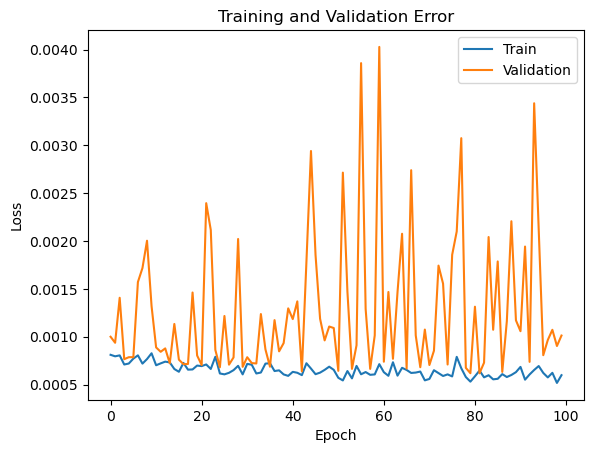

In [21]:
plot_training_error(history_lstm)

In [22]:
# Prepare data for future prediction
def prepare_future_data(data, prediction_days):
    X_future = data[-prediction_days:].reshape(1, -1, 1)
    return X_future

# Predict future prices
def predict_future_prices(model, data, future_days):
    predictions = []
    current_batch = data[-future_days:].reshape(1, future_days, 1)

    for _ in range(future_days):
        current_pred = model.predict(current_batch)[0]
        predictions.append(current_pred)
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
    return np.array(predictions).reshape(-1, 1)

# Inverse transform the predictions
def inverse_transform_predictions(scaler, predictions):
    return scaler.inverse_transform(predictions)

In [23]:
# Number of days to predict into the future
future_days = 30

# Prepare data for future prediction
X_future = prepare_future_data(df_scaled, future_days)

# Predict future prices
future_predictions = predict_future_prices(model_lstm, df_scaled, future_days)

# Inverse transform the predictions
future_predictions_inverse = inverse_transform_predictions(df_scaler, future_predictions)

1/1 [==============================] - 0s 8ms/step


In [24]:
# Plot the future predictions
def plot_future_predictions(ticker, future_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(future_pred, color='red', label='Future Predictions')
    plt.title(f'Future Predicted Values for {TICK}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

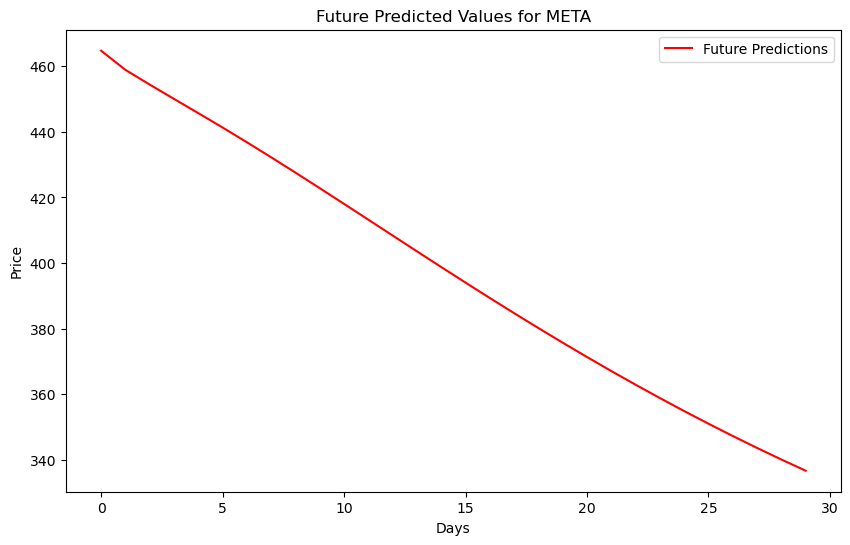

In [25]:
# Usage example for plotting predictions for specified tickers
plot_future_predictions(TICK, future_predictions_inverse)